Ce notebook décrit le processus de génération d'une image HDR et d'extraction des paramètres d'illuminance à partir d'une bracket d'images en format DNG (RAW) prises avec la caméra Ricoh Theta Z1.

###Dequoi avez-vous besoin avant de débuter ?

1. Une **BRACKET**, constitué de 11 images en format DNG (important) prises avec  la caméra Ricoh Theta Z1, avec les paramètres suivants :

        White balance mode : 5000K  
        Aperture : 5.6  
        ISO sensitivity : 100
Les exposures times (shutter speed) n'ont pas à être fixes. Voici ceux que nous avons utilisé pour le processus de calibration :

        Exposure times : [1 / 6400, 1 / 2000, 1 / 640, 1 / 320, 1 / 125, 1 / 25, 1 / 5, 1 / 2.5, 1, 2, 5]
Vous trouverez plus d'info sur les paramètres ici : 
https://support.theta360.com/uk/manual/z1/content/add_info/add_info_01.html



####Un mot sur la calibration. 
Afin de calibrer la Theta Z1, nous avons utilisé les étapes décrites dans le processus suivant

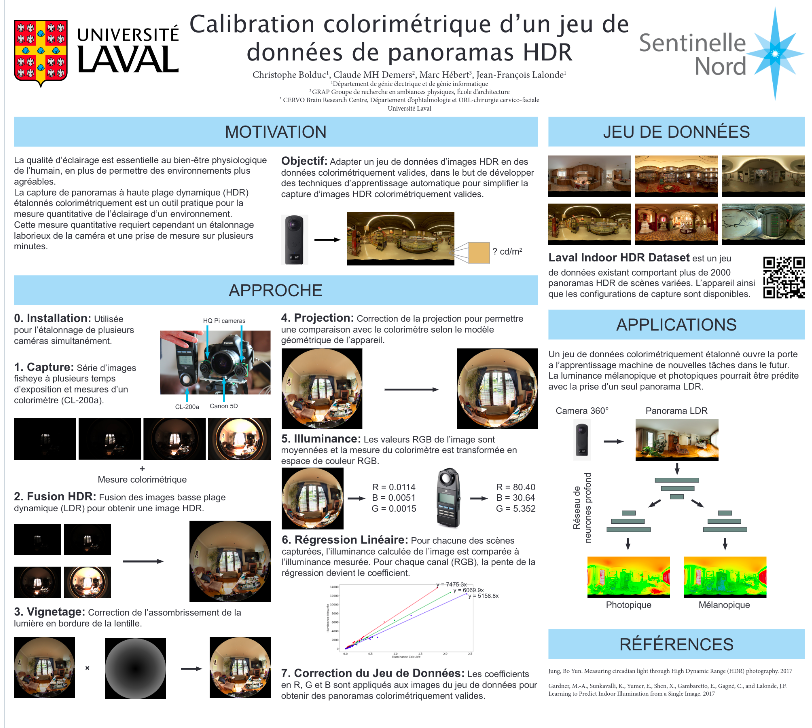


Les étapes qui viennent reproduisent les étapes 2 - Fusion HDR, 3 - Vignetage et 4 - Projection sur votre **BRACKET**.


### Requis avant le début

In [ ]:
# Les packages suivants sont nécessaires pour exécuter le code.
# Dans Google Colab, ils peuvent être installés de cette façon :
!pip install rawpy imageio dtcwt loguru OpenEXR Pillow
!sudo apt-get install libfreeimage3 libfreeimage-dev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.8/70.8 KB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dtcwt: filename=dtcwt-0.12.0-py3-none-any.whl size=87884 sha256=b8efdcf9dbcdb72f730a6efee34f09c9bc5350ac9f2d949d71260a834f2d9b6e
  Stored in directory: /root/.cache/pip/wheels/cb/49/64/2d60489d01a066f10aaa5763ef60c12fae2054cc7462a081f6
  Created wheel for OpenEXR: filename=OpenEXR-1.3.9-cp38-cp38-linux_x86_64.whl size=246152 sha256=f9b72c47480a8397ba5f7caa50d55b64262aa0f6f88153dae65d45452ffa2fb1
  Stored in directory: /root/.cache/pip/wheels/08/0a/f8/72574d2556e16bd07bf523d4e903110a0519921c2a345ad2cc
Successfully built dtcwt OpenEXR


In [ ]:
# Importation des modules
import os
import rawpy
import numpy as np
from loguru import logger
from PIL import Image
import imageio
from numba import jit

os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
import cv2

### Fusion HDR
1. Définition du chemin vers le dossier de la **BRACKET** (les photos DNG)

In [ ]:
# Mount Google Drive
# Dans Colab seulement
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Set path to photos and photo folder
path_to_bracket = './gdrive/path/to/bracket'
path_to_photos = [os.path.join(path_to_bracket, path_to_photo) for path_to_photo in os.listdir(path_to_bracket) if path_to_photo[-4:] == '.DNG']

2.  Définition des paramètres de la caméra (exposure times), à changer pour vos paramètres.



In [ ]:
# Seting parameters of the camera :
# Camera exposure times
exposure_times = np.array([
    1/6400,
    1/2000,
    1/640,
    1/320,
    1/125,
    1/25,
    1/5,
    1/2.5,
    1,
    2,
    5], dtype=np.float32)

3. Fusion HDR : on se sert de la fonction merge_debevec() du module opencv pour générer l'image HDR à partir des images DNG

    [Plus d'infos sur la génération d'une image HDR](https://docs.opencv.org/3.4/d2/df0/tutorial_py_hdr.html)

In [ ]:
# Allocate each DNG image to a numpy matrix inside the DNG_images_arrays list

def io_read_dng_image(path_to_photo):
    img = rawpy.imread(path_to_photo).postprocess(no_auto_bright=True, gamma=(1, 1))
    #logger.info('DNG image at ' + path_to_photo + ' was allocated.')
    return img
DNG_images_arrays = list(map(io_read_dng_image, path_to_photos))

In [ ]:
# Merge DNG images to HDR panorama using Debevec method
merge_debevec = cv2.createMergeDebevec()
hdr_debevec = merge_debevec.process(DNG_images_arrays, times=exposure_times)

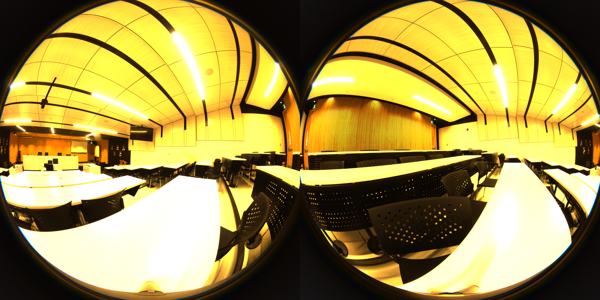

In [ ]:
# HDR image preview
display(
    Image.fromarray(np.clip(hdr_debevec, 0, 255).astype('uint8')).resize((600,600//2))
)

4. Sauvegarde de l'image HDR

In [ ]:
path_to_destination_file = "./"
image_name = 'NOM_DE_MON_IMAGE'
filename = image_name + '.exr'

cv2.imwrite(os.path.join(path_to_destination_file, filename), hdr_debevec)

In [ ]:
# On Google Colab only
# Download file to local computer
from google.colab import files
files.download(os.path.join(path_to_destination_file, filename))